# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [2]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43, 0.44, 0.47],
                                                std=[0.20, 0.20, 0.20])
                       ])
                       )
data_test = dset.SVHN('./data/', split='test',
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize(mean=[0.43, 0.44, 0.47],
                                               std=[0.20, 0.20, 0.20])
                      ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [3]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [4]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor


class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [5]:
nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10),
)
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [6]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?


def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train()  # Enter train mode

        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]

            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)

        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" %
              (ave_loss, train_accuracy, val_accuracy))

    return loss_history, train_history, val_history


def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader

    Returns: accuracy as a float value between 0 and 1
    """
    model.eval()  # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!

    #raise Exception("Not implemented")
    correct = 0
    total_samples = 0
    for x, y in loader:
        total_samples += y.shape[0]
        prediction = torch.argmax(model(x), dim=1)
        correct += torch.sum(prediction == y)

    return float(correct)/total_samples


loss_history, train_history, val_history = train_model(
    nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 1.811259, Train accuracy: 0.420725, Val accuracy: 0.545560
Average loss: 1.454580, Train accuracy: 0.579804, Val accuracy: 0.604942
Average loss: 1.384367, Train accuracy: 0.615620, Val accuracy: 0.637090


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [7]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10),
)
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(
    nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.186604, Train accuracy: 0.200201, Val accuracy: 0.227903
Average loss: 1.990464, Train accuracy: 0.287547, Val accuracy: 0.348577
Average loss: 1.784070, Train accuracy: 0.390301, Val accuracy: 0.404478
Average loss: 1.700602, Train accuracy: 0.426936, Val accuracy: 0.426933
Average loss: 1.679393, Train accuracy: 0.436030, Val accuracy: 0.426660


Добавьте слой с Batch Normalization

In [8]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10),
)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(
    nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.177558, Train accuracy: 0.258062, Val accuracy: 0.341274
Average loss: 1.996149, Train accuracy: 0.378971, Val accuracy: 0.412736
Average loss: 1.889072, Train accuracy: 0.433607, Val accuracy: 0.462494
Average loss: 1.813220, Train accuracy: 0.471846, Val accuracy: 0.498806
Average loss: 1.752771, Train accuracy: 0.495820, Val accuracy: 0.511910


Добавьте уменьшение скорости обучения по ходу тренировки.

In [9]:
def train_model_s(model, train_loader, val_loader, loss, optimizer, schedulers, num_epochs):
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train()  # Enter train mode

        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]

            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)

        schedulers.step()

        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" %
              (ave_loss, train_accuracy, val_accuracy))

    return loss_history, train_history, val_history

In [10]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.BatchNorm1d(100, eps=1e-3),
    nn.ReLU(inplace=True),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100, eps=1e-3),
    nn.ReLU(inplace=True),
    nn.Linear(100, 10),
)


optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
schedulers = optim.lr_scheduler.LambdaLR(
    optimizer, lr_lambda=[lambda epoch: 0.99**epoch])
loss_history, train_history, val_history = train_model_s(
    nn_model, train_loader, val_loader, loss, optimizer, schedulers, 10)

Average loss: 2.201585, Train accuracy: 0.246579, Val accuracy: 0.326667
Average loss: 2.030529, Train accuracy: 0.339351, Val accuracy: 0.368029
Average loss: 1.930073, Train accuracy: 0.379825, Val accuracy: 0.396560
Average loss: 1.866004, Train accuracy: 0.412142, Val accuracy: 0.433622
Average loss: 1.824845, Train accuracy: 0.434273, Val accuracy: 0.456146
Average loss: 1.797716, Train accuracy: 0.454800, Val accuracy: 0.460856
Average loss: 1.781193, Train accuracy: 0.465174, Val accuracy: 0.478466
Average loss: 1.768740, Train accuracy: 0.475463, Val accuracy: 0.479216
Average loss: 1.762643, Train accuracy: 0.478296, Val accuracy: 0.487134
Average loss: 1.758407, Train accuracy: 0.477170, Val accuracy: 0.485701


In [11]:
schedulers.get_lr()

[0.0009043820750088044]

# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [12]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)


def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset

    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval()  # Evaluation mode

    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!

#     raise Exception("Not implemented")
    sampler = SubsetSampler(indices)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         sampler=sampler)
    predictions = []
    ground_truth = []
    for x, y in loader:
        predictions.extend(torch.argmax(model(x), dim=1).tolist())
        ground_truth.extend(y.data.tolist())
    return predictions, ground_truth


# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

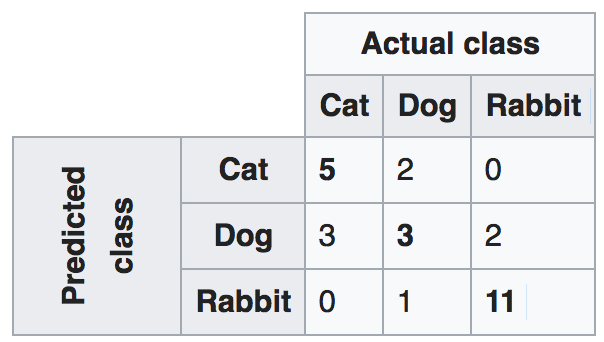

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

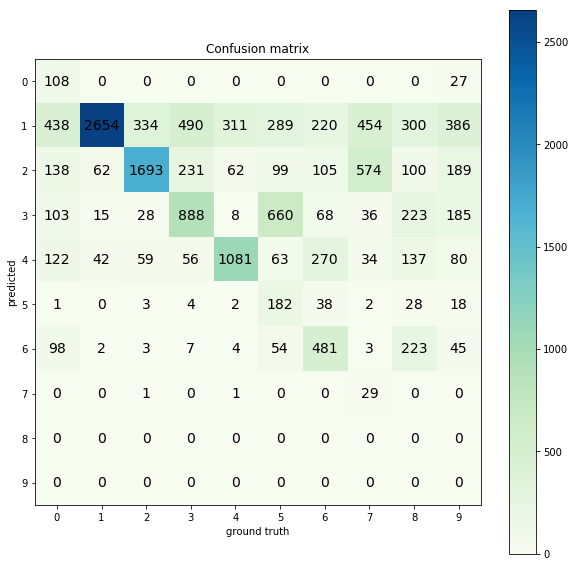

In [13]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix

    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth

    """
    # Adapted from
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10, 10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14,
                     horizontalalignment='center', verticalalignment='center')


def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples

    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """

    confusion_matrix = np.zeros((10, 10), np.int)

    # TODO: Implement filling the prediction matrix
    for p, gt in zip(predictions, ground_truth):
        confusion_matrix[p, gt] += 1
    return confusion_matrix


confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

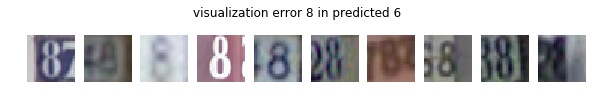

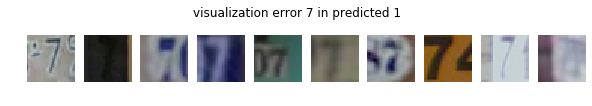

In [14]:
data_train_images = dset.SVHN('./data/', split='train')


def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset

    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10, 1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1, to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)


def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 

    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!

#     raise Exception("Not implemented")
    indices = []
    for i, dt in enumerate(zip(predictions, groud_truth)):
        p, gt = dt
        if p == predicted_class and gt == gt_class:
            indices.append(val_indices[i])
    visualize_images(
        indices, data, f'visualization error {gt_class} in predicted {predicted_class}')


visualize_predicted_actual(6, 8, predictions, gt,
                           np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt,
                           np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на валидацонной выборке должна быть доведена до **60%**

За лучший результат в группе вы получите дополнительные баллы :)

In [17]:
# Experiment here!
import pickle
import os.path as path


def search_param(train_loader, val_loader, lr, l2, epochs):
    nn_model = nn.Sequential(
        Flattener(),
        nn.Linear(3*32*32, 100),
        nn.BatchNorm1d(100),
        nn.ReLU(inplace=True),
        nn.Linear(100, 100),
        nn.BatchNorm1d(100),
        nn.ReLU(inplace=True),
        nn.Linear(100, 10),
        nn.BatchNorm1d(10),
        #         nn.Softmax(1),
    )

    loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
    optimizer = optim.Adadelta(nn_model.parameters(), lr=lr, weight_decay=l2)
    schedulers = optim.lr_scheduler.LambdaLR(
        optimizer, lr_lambda=[lambda epoch: 0.9**epoch])
    loss_history, train_history, val_history = train_model_s(
        nn_model, train_loader, val_loader, loss, optimizer, schedulers, epochs)

    return loss_history, train_history, val_history, nn_model


batch_sizes = [64, 128]
lrs = [1, 1e-1, 1e-2]
regs = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
params = {
    'batch size': [],
    'lr': [],
    'l2': [],
    'accuracy': []
}
model_dir = 'data/models'
best_model = None
best_acc = 0
for bs in batch_sizes:
    train_loader = torch.utils.data.DataLoader(data_train, batch_size=bs,
                                               sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(data_train, batch_size=bs,
                                             sampler=val_sampler)
    for lr in lrs:
        for l2 in regs:
            params['batch size'].append(bs)
            params['lr'].append(lr)
            params['l2'].append(l2)
            print(bs, lr, l2)
            try:
                with open(path.join(model_dir, str(bs)+'_'+str(lr)+'_'+str(l2)+'.model'), 'rb') as f:
                    nn_model = pickle.load(f)
                    val_history = [compute_accuracy(nn_model, val_loader)]
            except FileNotFoundError:
                loss_history, train_history, val_history, nn_model = search_param(
                    train_loader, val_loader, lr, l2, 10)
                with open(path.join(model_dir, str(bs)+'_'+str(lr)+'_'+str(l2)+'.model'), 'wb') as f:
                    pickle.dump(nn_model, f)
                with open(path.join(model_dir, str(bs)+'_'+str(lr)+'_'+str(l2)+'.info'), 'wb') as f:
                    pickle.dump(loss_history, f)
                    pickle.dump(train_history, f)
                    pickle.dump(val_history, f)
            params['accuracy'].append(val_history[-1])
            print(f'current accuracy {val_history[-1]}')
            if best_acc < val_history[-1]:
                best_acc = val_history[-1]
                best_model = nn_model
nn_model = best_model
print(f'best accuracy {best_acc}')

64 1 0.1
current accuracy 0.3649580233431165
64 1 0.01
current accuracy 0.7144222237389939
64 1 0.001
current accuracy 0.7950993106272609
64 1 0.0001
current accuracy 0.8318886082861238
64 1 1e-05
current accuracy 0.8342775237185175
64 0.1 0.1
current accuracy 0.6974267968056788
64 0.1 0.01
current accuracy 0.7975564807862945
64 0.1 0.001
current accuracy 0.8097740768548222
64 0.1 0.0001
current accuracy 0.8121629922872159
64 0.1 1e-05
current accuracy 0.8134598320933725
64 0.01 0.1
current accuracy 0.7370827929834141
64 0.01 0.01
current accuracy 0.7166063749914682
64 0.01 0.001
current accuracy 0.7349668964575797
64 0.01 0.0001
current accuracy 0.7020681182171865
64 0.01 1e-05
current accuracy 0.717015903351307
128 1 0.1
current accuracy 0.525766159306532
128 1 0.01
current accuracy 0.7082110436147703
128 1 0.001
current accuracy 0.7973517166063749
128 1 0.0001
current accuracy 0.824994880895502
128 1 1e-05
current accuracy 0.8296362023070097
128 0.1 0.1
current accuracy 0.7415193502

In [18]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8061
